In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn
import os
from scipy import sparse

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2 anndata==0.6.4 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.0 


In this notebook, we'll apply BBKNN to four pancreas datasets generated with different technologies. We'll also take a look at how trimming and data scaling impact the results. The bulk of the analysis will be based on the [Seurat-like](https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb) scanpy tutorial, with BBKNN slotting into the `sc.pp.neighbors()` spot. We'll only make use of UMAP for visualisation as TSNE does not use the neighbour graph when constructing its dimensionality reduction, and that's the part of the analysis which BBKNN alters.

It should be noted that shall you choose to re-run the code, you may get slightly differing visuals, but the overall findings should still hold. If you wish to explore the objects in their current form, they can be downloaded from [ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip)

Download the pancreas data, in the form of SCESet objects compiled by Vlad Kiselev. This ensures compatible annotations between all the datasets with minimal risk of user error.

In [2]:
if not os.path.exists('rawdata-pancreas'):
    #download SCESet objects
    os.makedirs('rawdata-pancreas')
    os.system('wget https://scrnaseq-public-datasets.s3.amazonaws.com/scater-objects/baron-human.rds')
    os.system('wget https://scrnaseq-public-datasets.s3.amazonaws.com/scater-objects/muraro.rds')
    os.system('wget https://scrnaseq-public-datasets.s3.amazonaws.com/scater-objects/segerstolpe.rds')
    os.system('wget https://scrnaseq-public-datasets.s3.amazonaws.com/scater-objects/wang.rds')
    os.system('mv *.rds rawdata-pancreas')

SCESet is an R thing. Thankfully, there is a cool little bit of jupyter notebook wizardry known as Rmagic that allows you to run R from within a python notebook. This is installed via the package rpy2.

Be sure to check that whatever R is hooked up to rpy2 actually has SingleCellExperiment - for example, if conda'ing rpy2 in, conda fetches its own R which will not see your installed packages. In case you want to actually get into that R from outside the jupyter notebook, call `R.home()` from within Rmagic and add `/bin/R` to the path that comes up.

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R

if (!('SingleCellExperiment' %in% rownames(installed.packages())))
{
    source("https://bioconductor.org/biocLite.R")
    biocLite("SingleCellExperiment")
}

With that out of the way, let's get importing! Time for four rather similar blocks of code, creating R data frames for the counts and cell type annotations, followed by `AnnData` objects being created for them and minimal gene/read count filtering being performed. Let's start with the Baron data.

In [5]:
%%R -o counts -o annot

suppressMessages(library(SingleCellExperiment))

holder = readRDS('rawdata-pancreas/baron-human.rds')

counts = data.frame(counts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))

In [6]:
holder = []
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = counts.index
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Baron'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

And now the Muraro data. You'll notice a slight difference in `adata.var_names` parsing, as the Muraro dataset features the chromosome embedded as part of the gene name and we need to remove it.

In [7]:
%%R -o counts -o annot

suppressMessages(library(SingleCellExperiment))

holder = readRDS('rawdata-pancreas/muraro.rds')

counts = data.frame(normcounts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))

In [8]:
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = [item.split('__')[0] for item in counts.index]
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Muraro'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

The Segerstolpe data.

In [9]:
%%R -o counts -o annot

suppressMessages(library(SingleCellExperiment))

holder = readRDS('rawdata-pancreas/segerstolpe.rds')

counts = data.frame(counts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))

In [10]:
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = counts.index
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Segerstolpe'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

And the Wang data.

In [11]:
%%R -o counts -o annot

suppressMessages(library(SingleCellExperiment))

holder = readRDS('rawdata-pancreas/wang.rds')

counts = data.frame(normcounts(holder))
annot = data.frame(as.character(colData(holder)[,'cell_type1']))

In [12]:
holder.append(anndata.AnnData(X=counts.values).T)
holder[-1].X = sparse.csr_matrix(holder[-1].X)
holder[-1].var_names = counts.index
holder[-1].obs_names = counts.columns
holder[-1].obs['celltype'] = annot.values
holder[-1].obs['sample'] = 'Wang'
sc.pp.filter_cells(holder[-1], min_genes=200)
sc.pp.filter_genes(holder[-1], min_cells=3)

With all of the data imported as individual `AnnData` objects, we can merge them. Kick out any lingering ERCCs. After doing that, we can set up `.raw` as a precautionary measure (which we use to reconstruct the object in a more pristine form for mnnCorrect/CCA comparison purposes later!) and scale the data to 10,000 counts per cell.

In [13]:
adata = holder[0].concatenate(holder[1:], join='outer')
adata.X = adata.X.tocsr()
adata = adata[:,['ERCC' not in item.upper() for item in adata.var_names]]
adata.raw = sc.pp.log1p(adata, copy=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly variable genes. The thresholds were selected to aim for ~10% of all genes as highly variable.

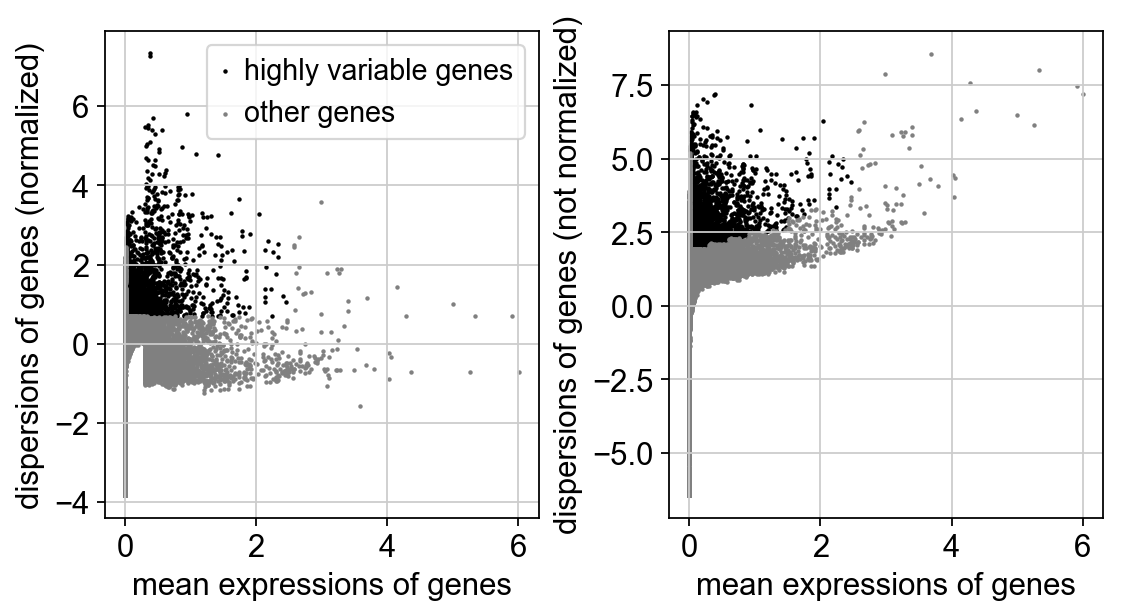

[2448, 24516]


In [14]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
sc.pl.filter_genes_dispersion(filter_result)
print([sum([i[0] for i in filter_result]),len(filter_result)])

Finish preprocessing the data by filtering it to the highly variable genes, log-transforming, scaling and performing PCA.

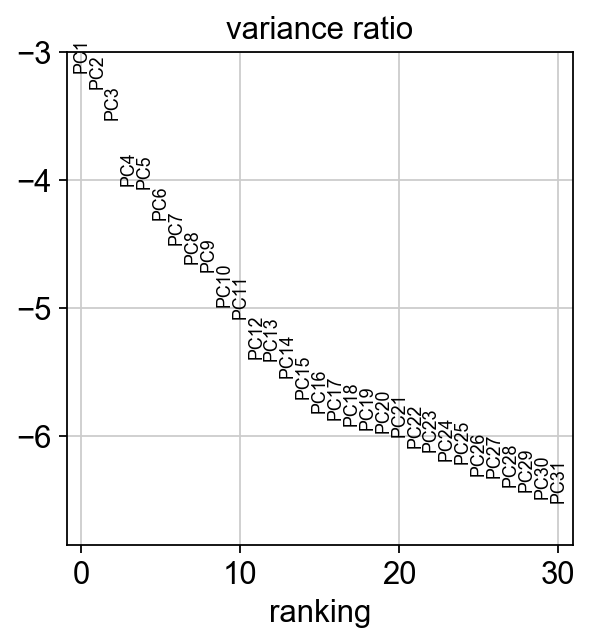

In [15]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata, log=True)

Use the elbow plot to propose a conservative 20 PC cutoff. Compute the standard neighbour graph and create the UMAP. While cells of similar type cluster together, the batch effect is glaring.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:04.49) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:09.54) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.38) --> found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


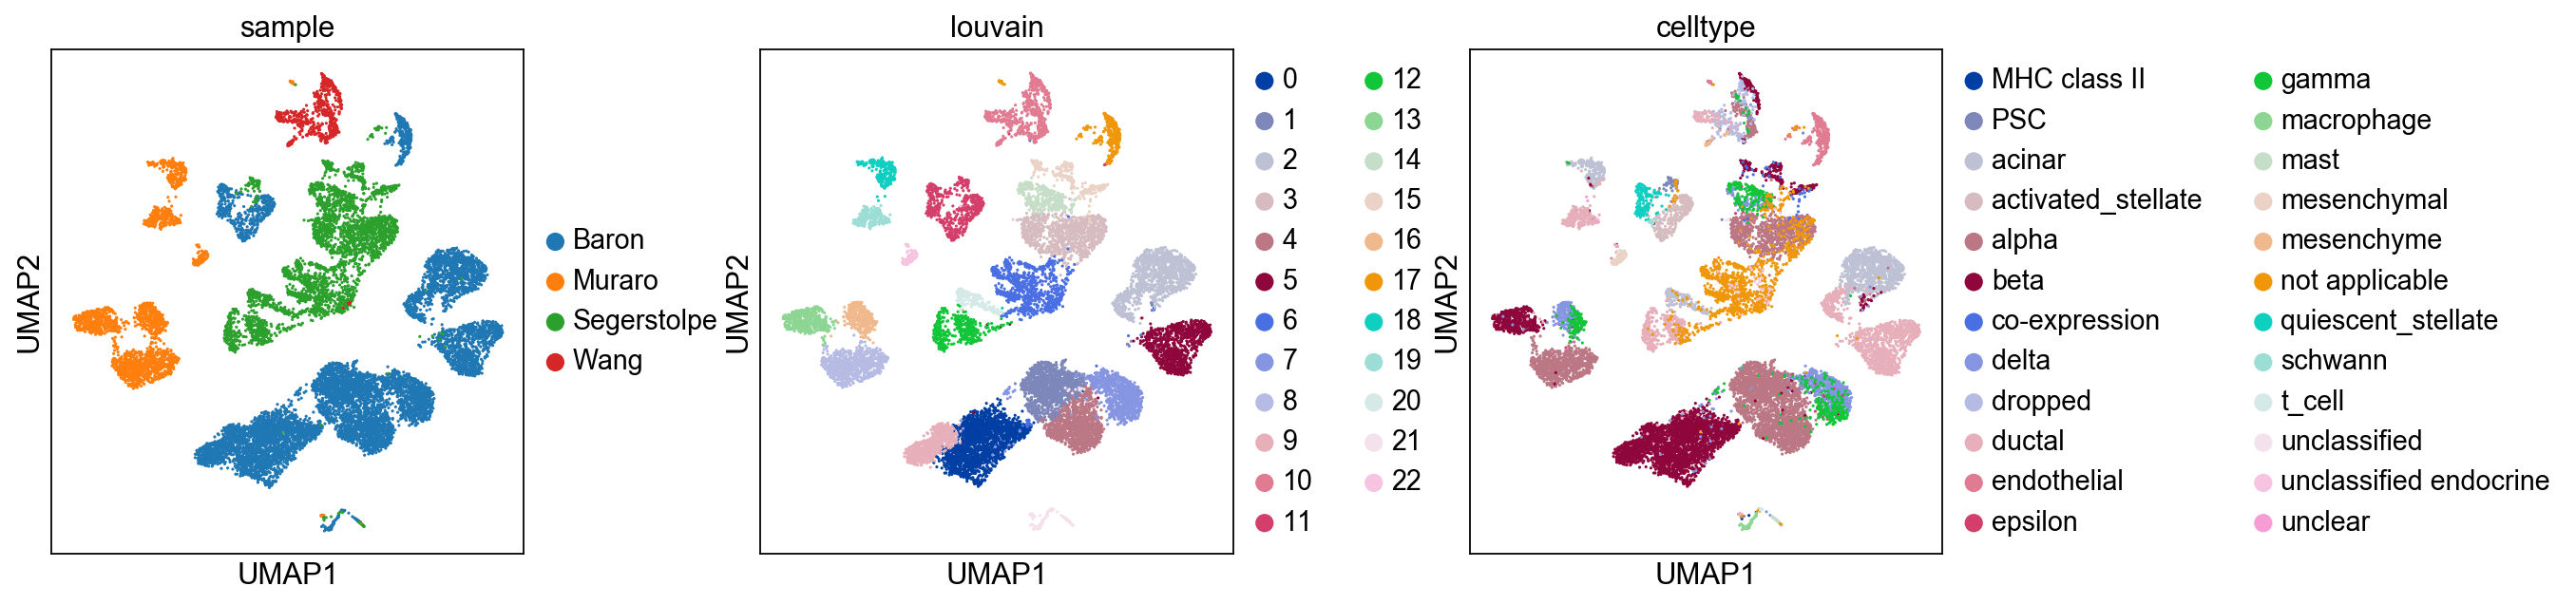

In [16]:
num_pcs = 20

sc.pp.neighbors(adata,n_pcs=num_pcs, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.louvain(adata)

sc.pl.umap(adata, color=['sample','louvain','celltype'])

#clear out the cluster plot colour map by hand, as otherwise it stays
del adata.uns['louvain_colors']

Replace regular neighbour inference with BBKNN, setting the `neighbors_within_batch` parameter to match our neighbour total for the previous step when multiplied by the number of batches. BBKNN uses `adata.obs['batch']` by default to split the batches, which is accurate in our case as each of our batches corresponds to one of the datasets. The `copy` flag is here to create separate objects for all the demonstrated BBKNN variants and can be skipped in most regular use.

The UMAP reveals the batches to be far better mixed than previously, while retaining cell type structure. It's the easiest to spot alpha (mauve) and beta (maroon) cells get joined together across the different datasets into cohesive entities, but this also applies to other cell types.

computing batch balanced neighbors
    finished (0:00:03.43) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:09.28) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.37) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


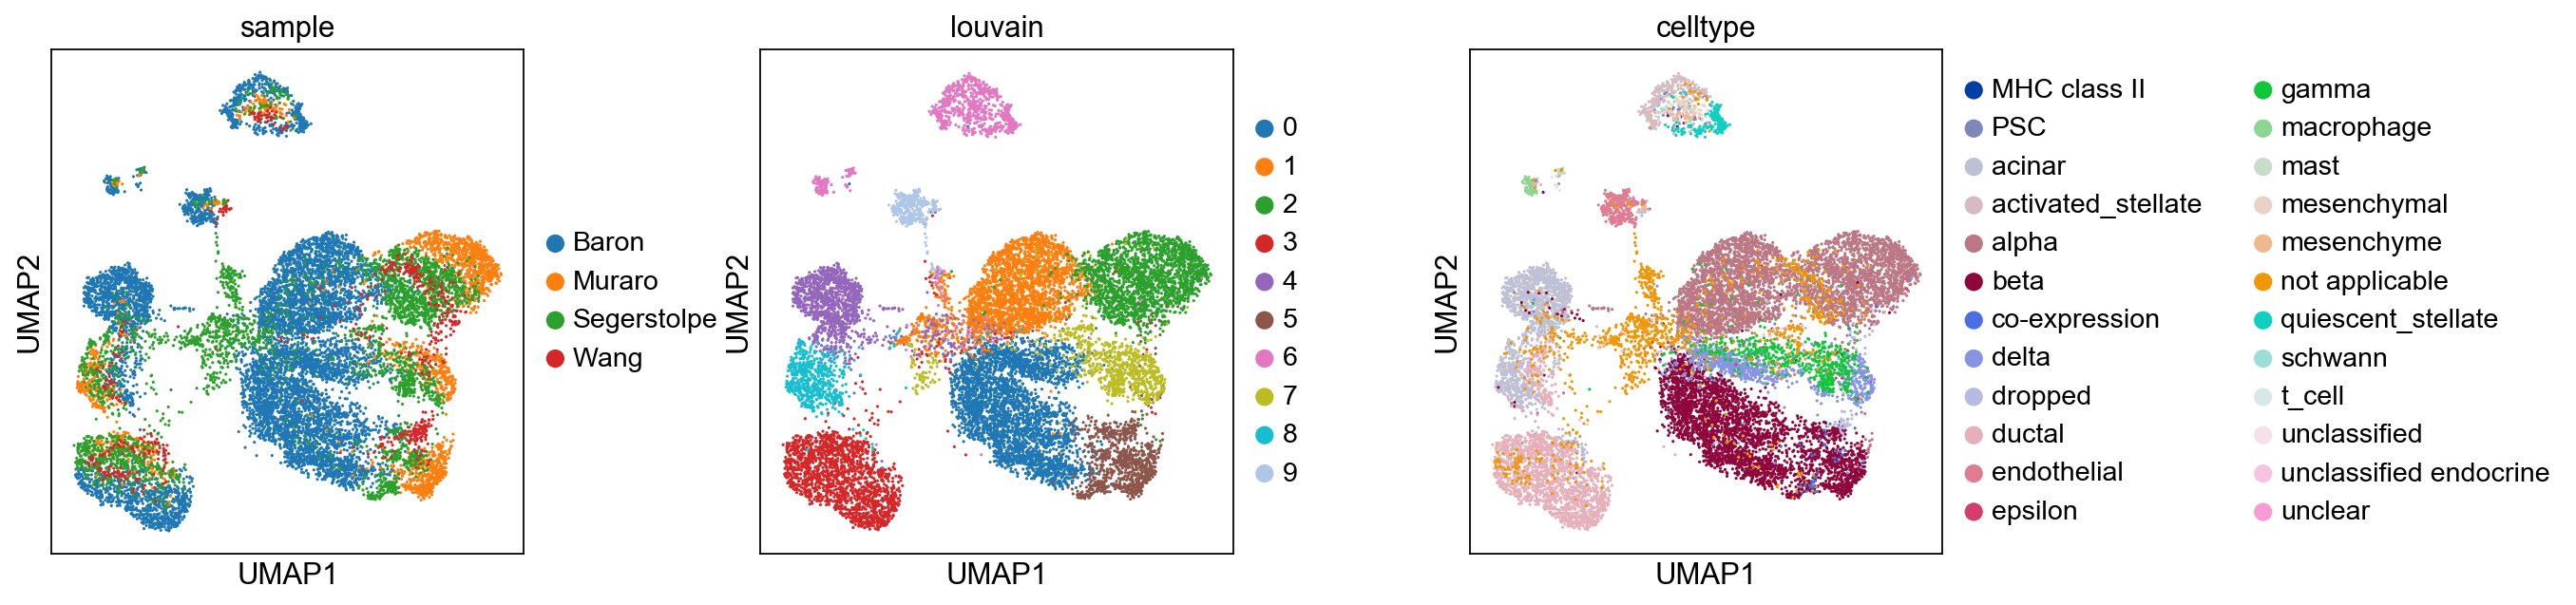

In [17]:
adata_bbknn = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, copy=True)
sc.tl.umap(adata_bbknn)
sc.tl.louvain(adata_bbknn)

sc.pl.umap(adata_bbknn, color=['sample','louvain','celltype'])

BBKNN also offers a `trim` parameter, which filters each cell's connections to a user-specified number of highest connectivities. This can help increase cell type separation at a potential slight cost to batch mixing, as evidenced by the plot below - the endothelial population becomes separated from an unrelated population from the Segerstolpe data, but the batches appear a bit more independent in the alpha population.

computing batch balanced neighbors
    finished (0:00:03.27) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:07.77) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.63) --> found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


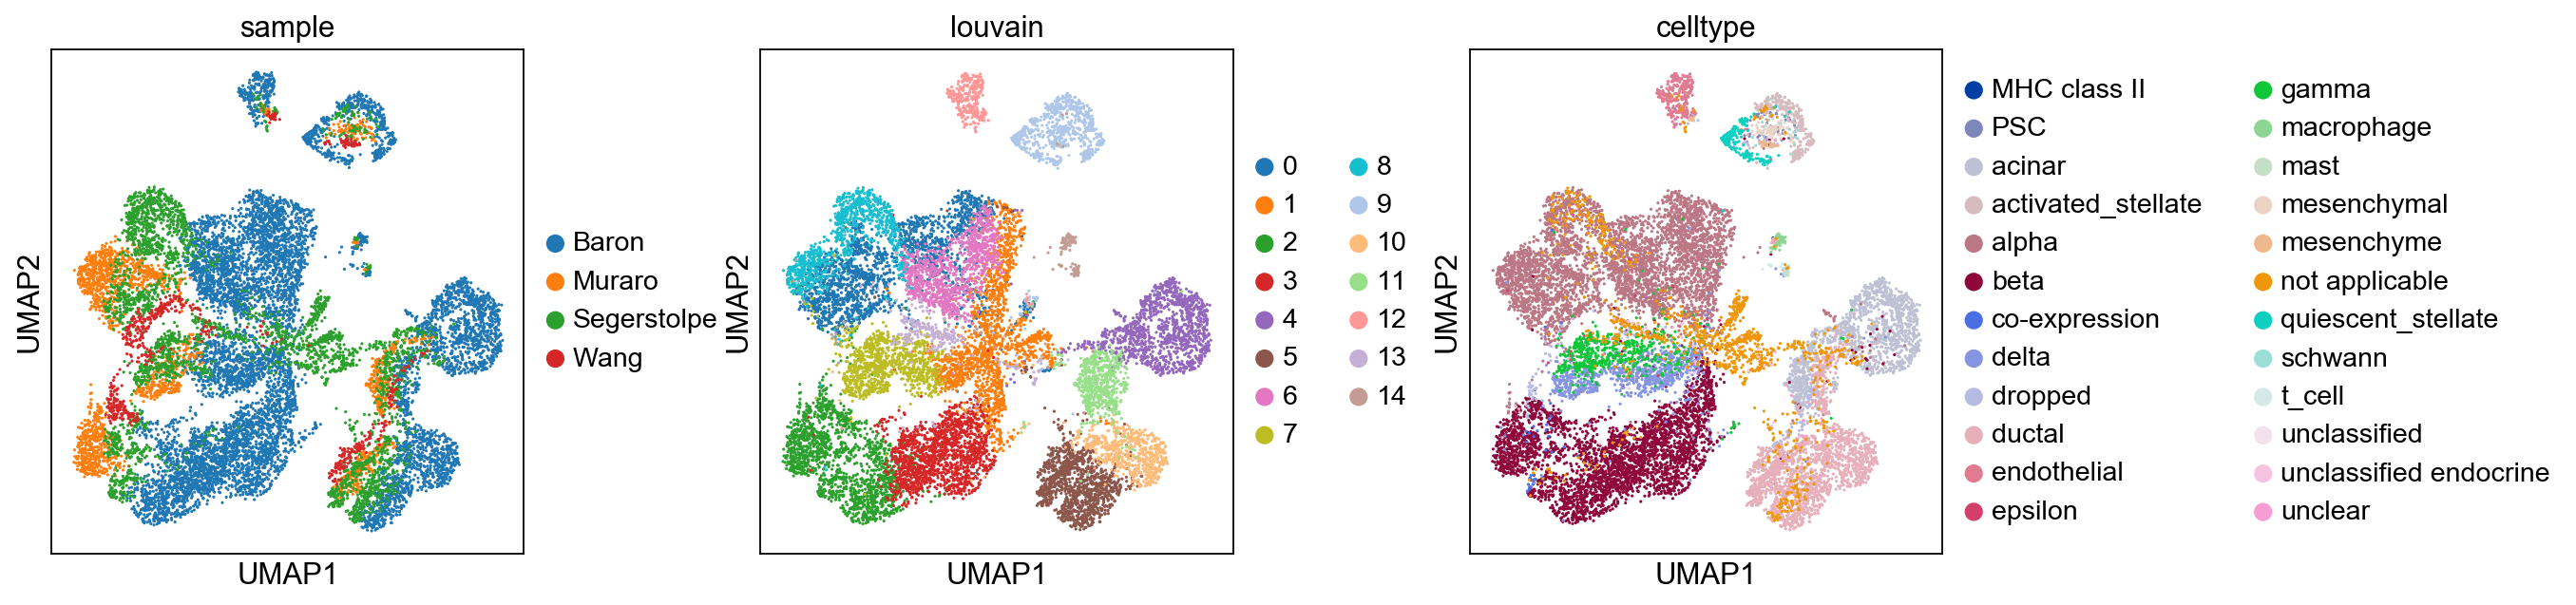

In [18]:
adata_bbknn_trim = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs, trim=50, copy=True)
sc.tl.umap(adata_bbknn_trim)
sc.tl.louvain(adata_bbknn_trim)

sc.pl.umap(adata_bbknn_trim, color=['sample','louvain','celltype'])

As of 1.3.0, BBKNN uses annoy by default to compute approximate neighbours. This has the potential to improve batch mixing, particularly in larger data, as connections will be present in the graph between more representatives of different batches. BBKNN does offer the option to compute exact neighbours, and does so by default via faiss. The default metric changes from angular to Euclidean.

computing batch balanced neighbors
    finished (0:00:02.74) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:09.26) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.67) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


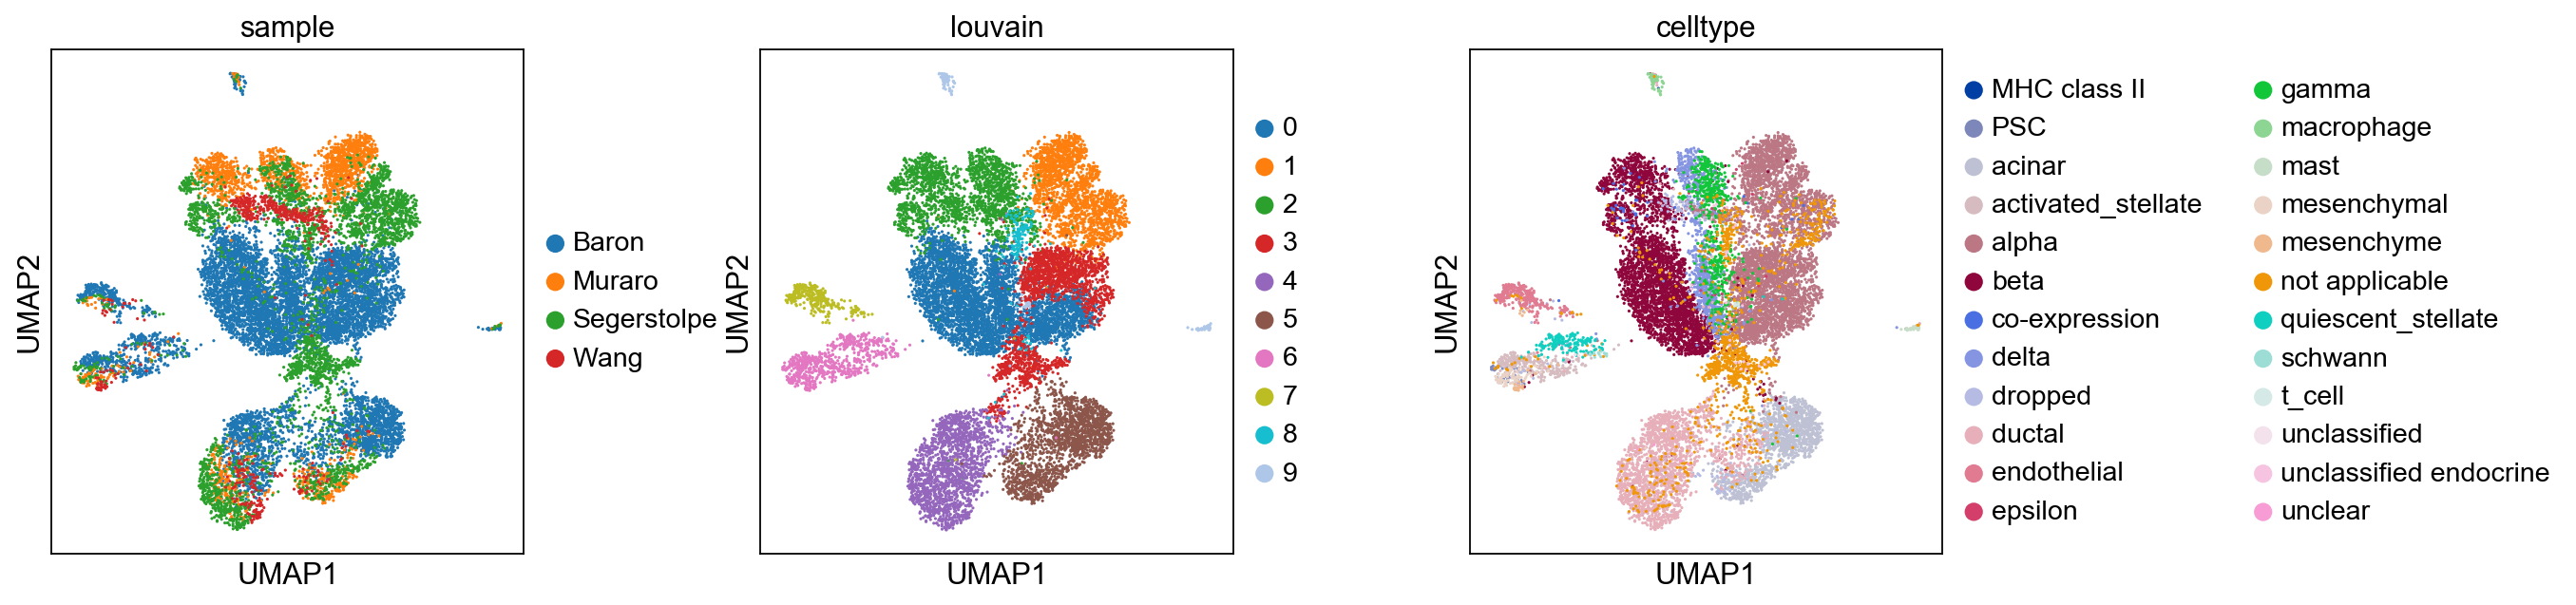

In [19]:
adata_bbknn_faiss = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs,
                                approx=False, copy=True)
sc.tl.umap(adata_bbknn_faiss)
sc.tl.louvain(adata_bbknn_faiss)

sc.pl.umap(adata_bbknn_faiss, color=['sample','louvain','celltype'])

However, faiss is quite difficult to install, and temperamental in execution (e.g. it doesn't work via `reticulate` on my machine). Setting `use_faiss` to `False`, or just failing to have faiss installed, makes BBKNN use `scipy.spatial.cKDTree` at a performance loss. Select non-Euclidean metrics are handled by `sklearn.neighbors.KDTree` at a further performance loss. Consult the [documentation](https://bbknn.readthedocs.io/en/latest/) for details.

computing batch balanced neighbors
    finished (0:00:03.54) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:09.03) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.70) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


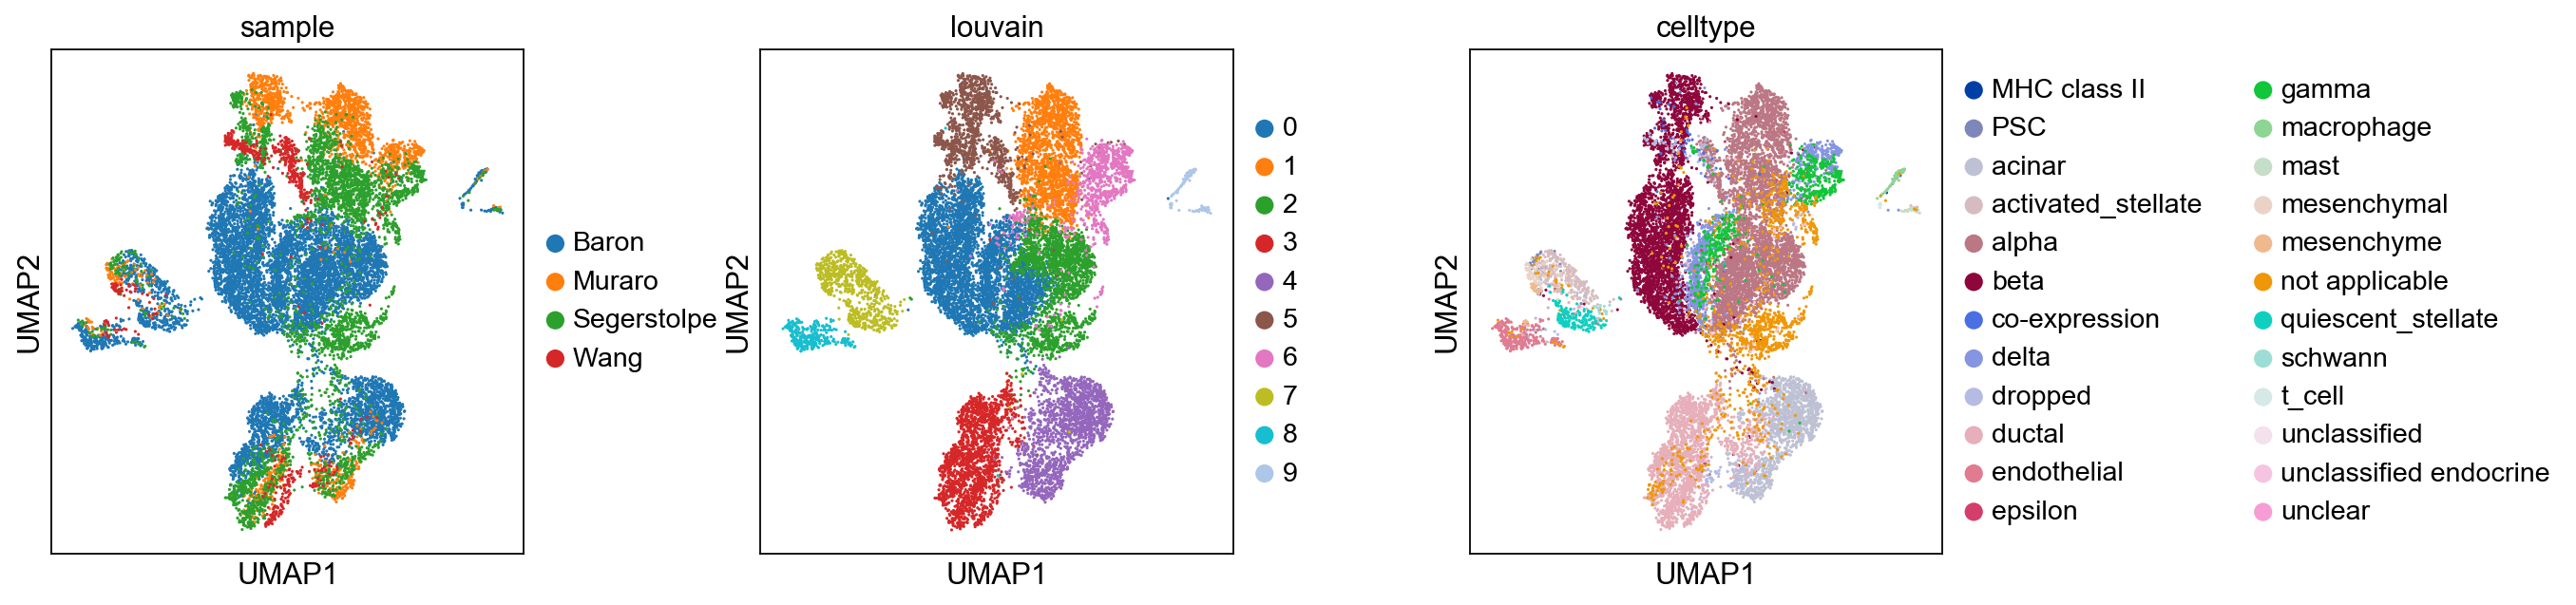

In [20]:
adata_bbknn_ckdtree = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=num_pcs,
                                  approx=False, use_faiss=False, copy=True)
sc.tl.umap(adata_bbknn_ckdtree)
sc.tl.louvain(adata_bbknn_ckdtree)

sc.pl.umap(adata_bbknn_ckdtree, color=['sample','louvain','celltype'])

Write out the objects for potential later use. All of them can be downloaded as a zipped up bundle from [ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip)

In [21]:
if not os.path.exists('objects-pancreas'):
    os.makedirs('objects-pancreas')

adata.write('objects-pancreas/pancreas.h5ad')
adata_bbknn.write('objects-pancreas/pancreas_bbknn.h5ad')
adata_bbknn_trim.write('objects-pancreas/pancreas_bbknn_trim.h5ad')
adata_bbknn_faiss.write('objects-pancreas/pancreas_bbknn_faiss.h5ad')
adata_bbknn_ckdtree.write('objects-pancreas/pancreas_bbknn_ckdtree.h5ad')